# Цель Блокнота

Смотрим на Бустинг XGBoost

# Import библиотек

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего


In [ ]:
plt.style.use('dark_background') # для модных черных рисунков

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Набор данных



Набор данных представляет собой статистику признаков автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный признак.

Среди указанных признаков приведен целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди признак есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий признак).

# Загрузка данных

Загружаем наши данные из файла по прямой ссылке на GitHub

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/mpti_ml/main/data/cars_moldova_no_dup_no_outliers.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


Список числовых и категориальных данных

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

# Подготовка данных

In [ ]:
from sklearn.model_selection import train_test_split #  функция разбиения на тренировочную и валидационную выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

**Считываем данные, разбиваем на тренировочную и валидационную**

In [ ]:
# не забываем удалить целевую переменную цену из признаков
X, y = DF.drop(columns = ['Price(euro)']), DF['Price(euro)']
features_names = list(DF.drop(columns = ["Price(euro)"]).columns)

# для XGBoost категориальные признаки всё равно придется перевести в числа
for col in cat_columns:
    X[col] = X[col].astype('category')

# разбиваем на тренировочную и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

Тут тоже есть свой формат данных, но он используется если используется т.н. автономный метод обучения `train`

In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(X_train,
                     label=y_train,
                     enable_categorical=True,)

dval = xgb.DMatrix(X_val,
                    y_val,
                    enable_categorical=True)

## Модель

Создаем Класс, как обычно

В целом уже стандартные и похожие вещи. Из особенностей

`objective` (`default=reg:squarederror`) - лосс-функция. Что оптимизируем, собственно
* `reg:squaredlogerror` - квадратичная ошибка
* `reg:logistic` - логистическая регрессия
* `reg:absoluteerror` - абсолютная ошибка
* `binary:logistic` - логистическая регрессия для бинарной классификации - на выходе вероятности
* `binary:logitraw`- то же самое - на выходе "сырые скоры" до применения логистического преобразования
* `multi:softmax` - мультиклассовая классификация




In [ ]:
model_reg = xgb.XGBRegressor(random_state = 42,
                            objective= 'reg:squarederror',
                              enable_categorical=True,
                             early_stopping_rounds=50,
                        n_estimators=500)


Применяем метод `fit` по традиции

In [ ]:
model_reg.fit(X_train,y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)]);

[0]	validation_0-rmse:5878.22648	validation_1-rmse:6061.84506
[1]	validation_0-rmse:4601.28712	validation_1-rmse:4838.53748
[2]	validation_0-rmse:3757.35404	validation_1-rmse:4057.84164
[3]	validation_0-rmse:3213.10424	validation_1-rmse:3569.99534
[4]	validation_0-rmse:2889.34175	validation_1-rmse:3297.88336
[5]	validation_0-rmse:2679.62649	validation_1-rmse:3135.71935
[6]	validation_0-rmse:2550.10558	validation_1-rmse:3051.73040
[7]	validation_0-rmse:2462.18236	validation_1-rmse:2991.15666
[8]	validation_0-rmse:2393.09256	validation_1-rmse:2952.11995
[9]	validation_0-rmse:2340.56795	validation_1-rmse:2930.22538
[10]	validation_0-rmse:2295.38610	validation_1-rmse:2908.24859
[11]	validation_0-rmse:2259.12954	validation_1-rmse:2890.58089
[12]	validation_0-rmse:2233.86553	validation_1-rmse:2891.54929
[13]	validation_0-rmse:2210.29411	validation_1-rmse:2888.66197
[14]	validation_0-rmse:2192.12731	validation_1-rmse:2882.93688
[15]	validation_0-rmse:2164.17383	validation_1-rmse:2876.07586
[1

In [ ]:
print("Лучшая Итерация: {}".format(model_reg.get_booster().best_iteration))

Лучшая Итерация: 17


**История обучения**

In [ ]:
results = model_reg.evals_result()

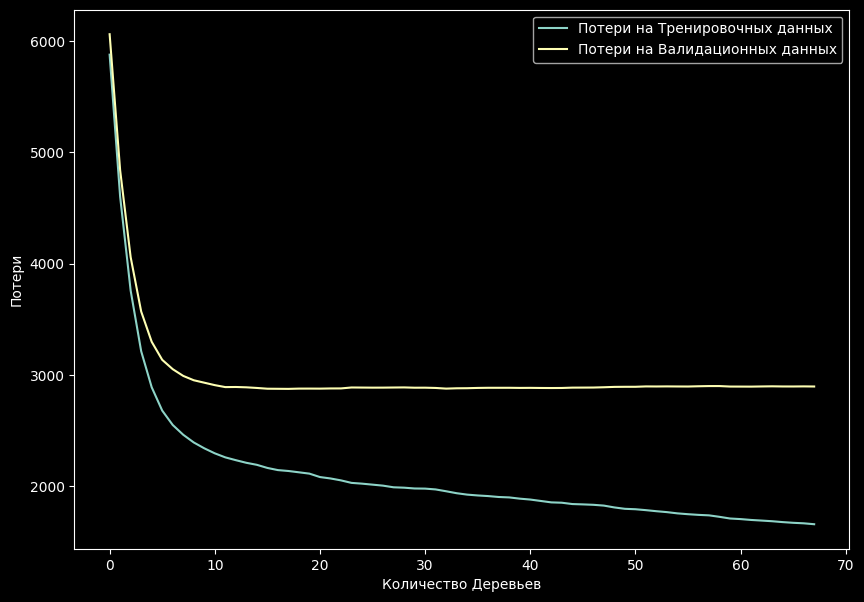

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Потери на Тренировочных данных")
plt.plot(results["validation_1"]["rmse"], label="Потери на Валидационных данных")
plt.xlabel("Количество Деревьев")
plt.ylabel("Потери")
plt.legend();

## Визуализация значимости признаков

In [ ]:
def feature_importance_plotter(model, features_names):
    """Отрисовка значимости признаков в виде горизонтальных столбчатых диаграмм.
    Параметры:
    ===========
    model: модель
    features_names: список имен признаков
    """
    feature_importance = model.feature_importances_

    sorted = np.argsort(feature_importance)

    ypos = np.arange(len(features_names))

    fig= plt.figure(figsize=(8,4))
    plt.barh(ypos, feature_importance[sorted])
    plt.xlim([0,1])
    plt.ylabel('Параметры')
    plt.xlabel('Значимость')
    plt.yticks(ypos,features_names[sorted] );

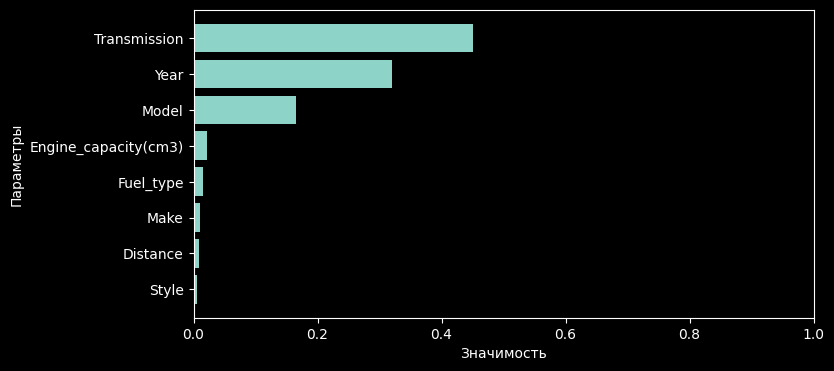

In [ ]:
feature_importance_plotter(model_reg, np.array(features_names))

## Оценка метрик

In [ ]:
def calculate_metric(model_pipe, X, y, metric = r2_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_reg, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_reg, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_reg, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_reg, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9249
r2 на валидационной выборке: 0.8687
mse на тренировочной выборке: 4565390.5416
mse на валидационной выборке: 8263710.7192


В нашем случае функцию для кросс-валидации нужно будет переписывать, поскольку `early_stopping_rounds` требует валидационного датасета. А `cross_validate` с такой задачей не справляется

## Визуализация ошибок от scikit-learn

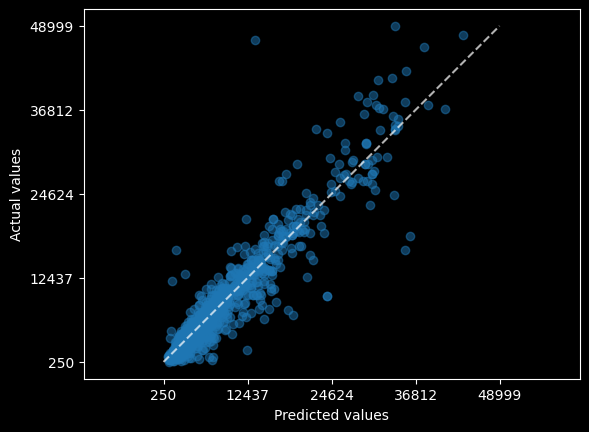

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_reg.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
        line_kwargs = {"color" : 'white'}

);

Небольшие выводы

* Модель регрессии от XGBoost ведет себя крайне уверенно

* В топе по значимости Трансмиссия, Год и Модель



# Сохранение / Загрузка

In [ ]:
# сохранение модели
model_reg.save_model("xgb_regressor.json")

In [ ]:
# Загрузка модели
model_ = xgb.XGBRegressor()
model_.load_model("xgb_regressor.json")

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9249
r2 на валидационной выборке: 0.8687
mse на тренировочной выборке: 4565390.5416
mse на валидационной выборке: 8263710.7192
